## hammurabiX tutorial e01
(we recommend users to run tutorials in docker image)

### synchrotron emission precision check

In this precision check we provide a simple case where the Galactic
synchrotron emission and Faraday rotation can be analytically calculated, with

- constant thermal electron density
- constant cosmic ray electron spectral index
- uniform magnetic field
- radial integration range $[0~\mathrm{kpc},r~\mathrm{kpc}]$

The mathematical description can be found in arXiv:1907.00207

In [1]:
import matplotlib
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import sys
sys.path.append('../hampyx/')
import hampyx as hpx
import scipy.special as sp

matplotlib.use('Agg')
%matplotlib inline

# CGS units
pi = 3.14159265358979
kpc = 3.0856775806e+21
eV = 1.60217733e-12
GeV = 1.e+9*eV
GHz = 1.e9
mG = 1.e-6
q = 4.8032068e-10
mc2 = 0.51099907e-3*GeV
cc = 2.99792458e+10
mc = mc2/cc
kB = 1.380622e-16
h = 6.626075540e-27

# convert brightness to CMB temperature
def t_conv(_t, _freq):
    """
    convert T_br into T_cmb
    :param _t: birghtness temperature 
    :param _freq: observing frequency
    :return: cmb blackbody temperature (fluctuation)
    """
    p = (h*_freq*GHz)/(kB*2.725)
    return _t*(np.exp(p)-1.)**2/(p**2*np.exp(p))

# total emissivity
def j_tot(_theta):
    """
    calculate total emissivity
    :param theta: parameter set
    :return: total emissivity in mK_cmb
    """
    b, r, l0, alpha, je, freq = _theta
    # CRE normalization
    gamma10 = 10.*GeV/mc2+1.0
    beta10 = np.sqrt(1.-1./gamma10)
    rslt = je*4.*pi*mc*(gamma10**alpha)/(1.e+4*GeV*beta10)
    # following Ribiki-Lightman eq(6.36)
    rslt *= np.sqrt(3)*(q**3)*b*mG/(mc2*(alpha+1))
    rslt *= sp.gamma(0.25*alpha+19./12.)*sp.gamma(0.25*alpha-1./12.)
    rslt *= (mc*2.*pi*freq*GHz/(3.*q*b*mG))**(0.5-0.5*alpha)
    # convert into mK_br
    rslt *= 1.e+3*cc*cc/(2.*kB*freq*GHz*freq*GHz)
    # convert into mK_cmb
    rslt = t_conv(rslt, freq)
    return rslt/(4.*pi)

# polarized emissivity
def j_pol(_theta):
    """
    calculate polarized emissivity
    :param theta: parameter set
    :return: total emissivity in mK_cmb
    """
    b, r, l0, alpha, je, freq = _theta
    # CRE normalization
    gamma10 = 10.*GeV/mc2+1.0
    beta10 = np.sqrt(1.-1./gamma10)
    rslt = je*4.*pi*mc*(gamma10**alpha)/(1.e+4*GeV*beta10)
    # following Ribiki-Lightman eq(6.36)
    rslt *= np.sqrt(3)*(q**3)*b*mG/(4.*mc2)
    rslt *= sp.gamma(0.25*alpha+7./12.)*sp.gamma(0.25*alpha-1./12.)
    rslt *= (mc*2.*pi*freq*GHz/(3.*q*b*mG))**(0.5-0.5*alpha)
    # convert into mK_br
    rslt *= 1.e+3*cc*cc/(2.*kB*freq*GHz*freq*GHz)
    # convert into mK_cmb
    rslt = t_conv(rslt, freq)
    return rslt/(4.*pi)

# analytic Stokes I
def i_th(_theta, _lon, _lat):
    """
    calculate synchrotron foreground total intensity per unit radius (in mK_cmb/cm)
    :param _theta: parameter set
    :param _lon: galactic longitude
    :param _lat: galactic latitude
    :return:
    """
    tmp = _theta
    lon = (_lon - tmp[2])*np.pi/180.
    lat = _lat*np.pi/180.
    # b_perp
    tmp[0] *= np.sqrt(1+tmp[1]**2 - (np.cos(lat)*np.cos(lon) + tmp[1]*np.sin(lat))**2)
    return j_tot(tmp)

# analytic polarized intensity
def pi_th(_theta, _lon, _lat):
    """
    calculate synchrotron foreground polarized intensity per unit radius (in mK_cmb/cm)
    without Faraday rotation correction
    :param theta: parameter set
    :return:
    """
    tmp = _theta
    lon = (_lon - tmp[2])*np.pi/180.
    lat = _lat*np.pi/180.
    # b_perp
    tmp[0] *= np.sqrt(1+tmp[1]**2 - (np.cos(lat)*np.cos(lon) + tmp[1]*np.sin(lat))**2)
    return j_pol(tmp)

# analytic Stokes Q
def q_th(_theta, _lon, _lat):
    """
    synchrotron Stokes Q per unit radius (in mK_cmb/cm)
    without Faraday rotation correction
    :param theta: parameter set
    :param lon: galactic longitude
    :param lat: galactic latitude
    :return:
    """
    tmp = _theta
    lon = (_lon - tmp[2])*np.pi/180.
    lat = _lat*np.pi/180.
    # b_perp
    tmp[0] *= np.sqrt(1+tmp[1]**2 - (np.cos(lat)*np.cos(lon) + tmp[1]*np.sin(lat))**2)
    # cos(2X)
    numerator = np.sin(lon)**2 - (tmp[1]*np.cos(lat)-np.sin(lat)*np.cos(lon))**2
    denominator = np.sin(lon)**2 + (tmp[1]*np.cos(lat)-np.sin(lat)*np.cos(lon))**2
    return j_pol(tmp)*numerator/denominator

# analytic Stokes U
def u_th(_theta, _lon, _lat):
    """
    synchrotron Stokes U per unit radius (in mK_cmb/cm)
    without Faraday rotation correction
    :param theta: parameter set
    :param lon: galactic longitude
    :param lat: galactic latitude
    :return:
    """
    tmp = _theta
    lon = (_lon - tmp[2])*np.pi/180.
    lat = _lat*np.pi/180.
    # b_perp
    tmp[0] *= np.sqrt(1+tmp[1]**2 - (np.cos(lat)*np.cos(lon) + tmp[1]*np.sin(lat))**2)
    # sin(2X)
    numerator = 2.*np.sin(lon)*(tmp[1]*np.cos(lat)-np.sin(lat)*np.cos(lon))
    denominator = np.sin(lon)**2 + (tmp[1]*np.cos(lat)-np.sin(lat)*np.cos(lon))**2
    return j_pol(tmp)*numerator/denominator

# analytic Faraday depth
def fd_th(_theta, _lon, _lat):
    """
    calculate Faraday depth per unit radius (in rad/cm3)
    :param theta: parameter set
    :param lon: galactic longitude
    :param lat: galactic latitude
    :return:
    """
    tmp = _theta
    lon = (_lon - tmp[2])*np.pi/180.
    lat = _lat*np.pi/180.
    # b_parallel
    tmp[0] *= (np.cos(lat)*np.cos(lon) + tmp[1]*np.sin(lat))
    return tmp[-1]*tmp[0]*mG*(-q**3/(2*pi*mc2**2))

- single shell precision (spin 0 field)

The output resolution is set as the same as simulation resolution

In [2]:
def precision_1shell_spin0(_freq, _res):
    """
    :param _freq: observational frequency
    :param _res: ratio between LoS integral radial bin length to total LoS radial depth
    :return:
    """
    # observable controllers
    nside = 64 # HEALPix Nside
    shell = 1 # number of integral shells (recommend single shell)
    radius = 4.0  # total LoS integral radius in unit kpc
    res = _res*radius  # radial resolution in unit kpc

    # field controllers
    bp = 6.0  # muG
    bv = 0
    l0 = 0.0
    alpha = 3
    je = 0.25
    freq = _freq  # affecting precision
    ne = 0.01  # pccm
    E0 = 10  # by definition

    # call hammurabiX wrapper
    obj = hpx.Hampyx(xml_path='../templates/params_template.xml',exe_path='/home/lab/hamx/build/hamx')
    # assuming the xml file is not prepared
    obj.del_par(['observable', 'sync'], 'all')
    obj.del_par(['observable','dust'], 'all')
    obj.add_par(['observable'], 'sync', {'cue': str(1),
                                         'freq': str(freq),
                                         'filename': 'dumy',
                                         'nside': str(nside)})
    obj.mod_par(['observable', 'dm'], {'cue': str(1), 'nside': str(nside)})
    obj.mod_par(['observable', 'faraday'], {'cue': str(1), 'nside': str(nside)})
    # mute all field output/input
    obj.del_par(['fieldio', 'breg'], 'all')
    obj.del_par(['fieldio', 'brnd'], 'all')
    obj.del_par(['fieldio', 'tereg'], 'all')
    obj.del_par(['fieldio', 'ternd'], 'all')
    obj.del_par(['fieldio', 'cre'], 'all')
    # calibrate simulation box
    obj.mod_par(['grid', 'shell', 'layer'], {'type': 'auto'})
    #obj.mod_par(['grid', 'shell', 'layer'], {'type': 'manual'})
    obj.mod_par(['grid', 'shell', 'layer', 'auto', 'shell_num'], {'value': str(shell)})
    obj.mod_par(['grid', 'shell', 'layer', 'auto', 'nside_sim'], {'value': str(nside)})
    
    obj.mod_par(['grid', 'shell', 'oc_r_max'], {'value': str(radius)})
    obj.mod_par(['grid', 'shell', 'gc_r_max'], {'value': str(radius+9.)})
    obj.mod_par(['grid', 'shell', 'gc_z_max'], {'value': str(radius+1.)})
    obj.mod_par(['grid', 'shell', 'oc_r_res'], {'value': str(res)})
    # fix GMF
    obj.mod_par(['magneticfield', 'regular'], {'cue': str(1), 'type': 'unif'})
    obj.mod_par(['magneticfield', 'regular', 'unif', 'bp'], {'value': str(bp)})
    obj.mod_par(['magneticfield', 'regular', 'unif', 'l0'], {'value': str(l0)})
    obj.mod_par(['magneticfield', 'regular', 'unif', 'bv'], {'value': str(bv)})
    obj.mod_par(['magneticfield', 'random'], {'cue': str(0)})
    # fix FE
    obj.mod_par(['thermalelectron', 'regular'], {'cue': str(1), 'type': 'unif'})
    obj.mod_par(['thermalelectron', 'regular', 'unif', 'n0'], {'value': str(ne)})
    obj.mod_par(['thermalelectron', 'regular', 'unif', 'r0'], {'value': str(radius)})
    obj.mod_par(['thermalelectron', 'random'], {'cue': str(0)})
    # fix CRE
    obj.mod_par(['cre'], {'type': 'unif'})
    obj.mod_par(['cre', 'unif', 'alpha'], {'value': str(alpha)})
    obj.mod_par(['cre', 'unif', 'E0'], {'value': str(10.0)})
    obj.mod_par(['cre', 'unif', 'j0'], {'value': str(je)})
    obj.mod_par(['cre', 'unif', 'r0'], {'value': str(radius)})
    # call hammurabi executable
    obj(True)
    # (in mK_cmb)
    qsim = obj.sim_map[('sync', str(freq), str(nside), 'Q')]*1.e+3
    usim = obj.sim_map[('sync', str(freq), str(nside), 'U')]*1.e+3
    isim = obj.sim_map[('sync', str(freq), str(nside), 'I')]*1.e+3
    fsim = obj.sim_map[('fd', 'nan', str(nside), 'nan')]

    ith = np.zeros_like(isim)
    pith = np.zeros_like(isim)
    qth = np.zeros_like(qsim)
    uth = np.zeros_like(usim)
    fth = np.zeros_like(fsim)
    for i in range(0, np.size(qth)):
        l, b = hp.pix2ang(nside, i, lonlat=True)
        ith[i] = i_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        pith[i] = pi_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        qth[i] = q_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        uth[i] = u_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        fth[i] = fd_th([bp, bv, l0, ne], l, b)*radius*kpc*1.e+4
    
    x = 2.*fth*(0.09/freq**2)
    qthc = ( qth*np.sin(x) - uth*(1-np.cos(x)) )/x
    uthc = ( uth*np.sin(x) + qth*(1-np.cos(x)) )/x
    
    # correction to pol. intensity from Faraday rotation
    #picorrect = 2.*abs(np.sin(0.5*x)/x)
    #pith = pith * picorrect
    pisim = np.sqrt(qsim**2+usim**2)
    
    fig = plt.figure(figsize=(9,9))
    gs = matplotlib.gridspec.GridSpec(20, 20)
    
    cbarmin = np.min((0,300))
    cbarmax = np.max((0,300))
    ax1 = fig.add_subplot(gs[0:6, 0:15])
    matplotlib.rcParams.update({'font.size': 15})
    hp.mollview(isim,min=cbarmin,max=cbarmax,
                norm='hist',cmap='coolwarm',sub=(1,3,1),hold=True,title=None,cbar=0)
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, fraction=0.015, pad=0.04)
    cbar.set_ticks([cbarmin,cbarmax])
    cbar.ax.set_yticklabels(['%.1f' % cbarmin, '%.1f' % cbarmax])
    cbar.ax.tick_params(labelsize=20)
    
    
    cbarmin = np.min((-0.001,0.001))
    cbarmax = np.max((-0.001,0.001))
    ax2 = fig.add_subplot(gs[6:12, 7:19])
    matplotlib.rcParams.update({'font.size': 15})
    hp.mollview((isim-ith),format='%.2g',min=cbarmin,max=cbarmax,
                cmap='coolwarm',sub=(1,3,2),hold=True,title=None,cbar=0)
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, fraction=0.015, pad=0.04)
    cbar.set_ticks([cbarmin,cbarmax])
    cbar.ax.set_yticklabels(['%.1g' % cbarmin, '%.1g' % cbarmax])
    cbar.ax.tick_params(labelsize=20)
    
    cbarmin = np.min(2.*(isim-ith)/(isim+ith))
    cbarmax = np.max(2.*(isim-ith)/(isim+ith))
    ax3 = fig.add_subplot(gs[12:19, 0:13])
    matplotlib.rcParams.update({'font.size': 15})
    hp.mollview(2.*(isim-ith)/(isim+ith),format='%.2g',min=cbarmin,max=cbarmax,
                cmap='coolwarm',sub=(1,3,3),hold=True,title=None,cbar=0)
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, fraction=0.015, pad=0.04)
    cbar.set_ticks([cbarmin,cbarmax])
    cbar.ax.set_yticklabels(['%.2g' % cbarmin, '%.2g' % cbarmax])
    cbar.ax.tick_params(labelsize=20)
    
    ax4 = fig.add_subplot(gs[9:11,0:7])
    ax4.hist(2.*(isim-ith)/(isim+ith),50,range=(-0.01,0.01))
    ax4.set_xticklabels(['{:,.0%}'.format(x) for x in ax4.get_xticks()])
    ax4.set_yticklabels([])
    ax4.tick_params(axis='both', which='major', labelsize='20', color='steelblue')
    
    plt.savefig('err_spin0_1shell.pdf')

/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:958: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:988: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-pack

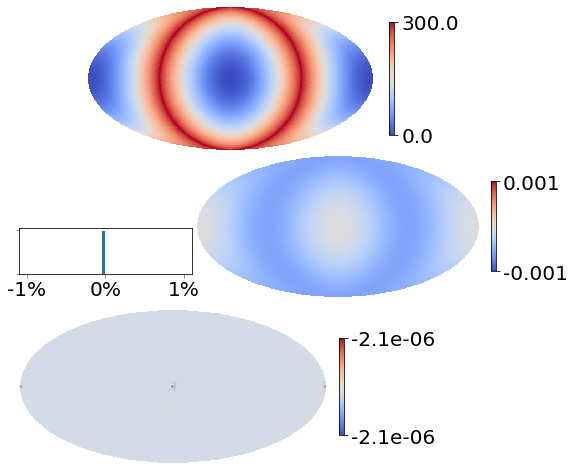

In [3]:
# radial resolution at 1% of total radius
precision_1shell_spin0(2.4,0.01)

- single shell precision (spin 2 field)

The output resolution is set as the same as simulation resolution

In [4]:
def precision_1shell_spin2(_freq, _res):
    """
    :param _freq: observational frequency
    :param _res: ratio between LoS integral radial bin length to total LoS radial depth
    :return:
    """
    # observable controllers
    nside = 64
    shell = 1
    radius = 4.0  # total LoS integral radius in unit kpc
    res = _res*radius  # radial resolution in unit kpc

    # field controllers
    bp = 6.0  # muG
    bv = 0
    l0 = 0.0
    alpha = 3
    je = 0.25
    freq = _freq  # affecting precision
    ne = 0.01  # pccm
    E0 = 10  # by definition

    # call hammurabiX wrapper
    obj = hpx.Hampyx(xml_path='../templates/params_template.xml',exe_path='/home/lab/hamx/build/hamx')
    # assuming the xml file is not prepared
    obj.del_par(['observable', 'sync'], 'all')
    obj.del_par(['observable','dust'], 'all')
    obj.add_par(['observable'], 'sync', {'cue': str(1),
                                         'freq': str(freq),
                                         'filename': 'dumy',
                                         'nside': str(nside)})
    obj.mod_par(['observable', 'dm'], {'cue': str(1), 'nside': str(nside)})
    obj.mod_par(['observable', 'faraday'], {'cue': str(1), 'nside': str(nside)})
    # mute all field output/input
    obj.del_par(['fieldio', 'breg'], 'all')
    obj.del_par(['fieldio', 'brnd'], 'all')
    obj.del_par(['fieldio', 'tereg'], 'all')
    obj.del_par(['fieldio', 'ternd'], 'all')
    obj.del_par(['fieldio', 'cre'], 'all')
    # calibrate simulation box
    obj.mod_par(['grid', 'shell', 'layer'], {'type': 'auto'})
    #obj.mod_par(['grid', 'shell', 'layer'], {'type': 'manual'})
    obj.mod_par(['grid', 'shell', 'layer', 'auto', 'shell_num'], {'value': str(shell)})
    obj.mod_par(['grid', 'shell', 'layer', 'auto', 'nside_sim'], {'value': str(nside)})
    
    obj.mod_par(['grid', 'shell', 'oc_r_max'], {'value': str(radius)})
    obj.mod_par(['grid', 'shell', 'gc_r_max'], {'value': str(radius+9.)})
    obj.mod_par(['grid', 'shell', 'gc_z_max'], {'value': str(radius+1.)})
    obj.mod_par(['grid', 'shell', 'oc_r_res'], {'value': str(res)})
    # fix GMF
    obj.mod_par(['magneticfield', 'regular'], {'cue': str(1), 'type': 'unif'})
    obj.mod_par(['magneticfield', 'regular', 'unif', 'bp'], {'value': str(bp)})
    obj.mod_par(['magneticfield', 'regular', 'unif', 'l0'], {'value': str(l0)})
    obj.mod_par(['magneticfield', 'regular', 'unif', 'bv'], {'value': str(bv)})
    obj.mod_par(['magneticfield', 'random'], {'cue': str(0)})
    # fix FE
    obj.mod_par(['thermalelectron', 'regular'], {'cue': str(1), 'type': 'unif'})
    obj.mod_par(['thermalelectron', 'regular', 'unif', 'n0'], {'value': str(ne)})
    obj.mod_par(['thermalelectron', 'regular', 'unif', 'r0'], {'value': str(radius)})
    obj.mod_par(['thermalelectron', 'random'], {'cue': str(0)})
    # fix CRE
    obj.mod_par(['cre'], {'type': 'unif'})
    obj.mod_par(['cre', 'unif', 'alpha'], {'value': str(alpha)})
    obj.mod_par(['cre', 'unif', 'E0'], {'value': str(10.0)})
    obj.mod_par(['cre', 'unif', 'j0'], {'value': str(je)})
    obj.mod_par(['cre', 'unif', 'r0'], {'value': str(radius)})
    # call hammurabi executable
    obj(True)
    # (in mK_cmb)
    qsim = obj.sim_map[('sync', str(freq), str(nside), 'Q')]*1.e+3
    usim = obj.sim_map[('sync', str(freq), str(nside), 'U')]*1.e+3
    isim = obj.sim_map[('sync', str(freq), str(nside), 'I')]*1.e+3
    fsim = obj.sim_map[('fd', 'nan', str(nside), 'nan')]

    ith = np.zeros_like(isim)
    pith = np.zeros_like(isim)
    qth = np.zeros_like(qsim)
    uth = np.zeros_like(usim)
    fth = np.zeros_like(fsim)
    for i in range(0, np.size(qth)):
        l, b = hp.pix2ang(nside, i, lonlat=True)
        ith[i] = i_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        pith[i] = pi_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        qth[i] = q_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        uth[i] = u_th([bp, bv, l0, alpha, je, freq], l, b)*radius*kpc
        fth[i] = fd_th([bp, bv, l0, ne], l, b)*radius*kpc*1.e+4
    
    x = 2.*fth*(0.09/freq**2)
    qthc = ( qth*np.sin(x) - uth*(1-np.cos(x)) )/x
    uthc = ( uth*np.sin(x) + qth*(1-np.cos(x)) )/x
    
    # correction to pol. intensity from Faraday rotation
    #picorrect = 2.*abs(np.sin(0.5*x)/x)
    #pith = pith * picorrect
    pisim = np.sqrt(qsim**2+usim**2)
    
    fig = plt.figure(figsize=(9,9))
    gs = matplotlib.gridspec.GridSpec(20, 20)
    
    cbarmin = np.min((-200,200))
    cbarmax = np.max((-200,200))
    ax1 = fig.add_subplot(gs[0:6, 0:15])
    matplotlib.rcParams.update({'font.size': 15})
    hp.mollview(qsim,min=cbarmin,max=cbarmax,
                norm='hist',cmap='coolwarm',sub=(1,3,1),hold=True,title=None,cbar=0)
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, fraction=0.015, pad=0.04)
    cbar.set_ticks([cbarmin,cbarmax])
    cbar.ax.set_yticklabels(['%.1f' % cbarmin, '%.1f' % cbarmax])
    cbar.ax.tick_params(labelsize=20)
    
    
    cbarmin = np.min((-1,1))
    cbarmax = np.max((-1,1))
    ax2 = fig.add_subplot(gs[6:12, 7:19])
    matplotlib.rcParams.update({'font.size': 15})
    hp.mollview((qsim-qthc),format='%.2g',min=cbarmin,max=cbarmax,
                cmap='coolwarm',sub=(1,3,2),hold=True,title=None,cbar=0)
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, fraction=0.015, pad=0.04)
    cbar.set_ticks([cbarmin,cbarmax])
    cbar.ax.set_yticklabels(['%.1g' % cbarmin, '%.1g' % cbarmax])
    cbar.ax.tick_params(labelsize=20)
    
    cbarmin = np.min((-0.1,0.1))
    cbarmax = np.max((-0.1,0.1))
    ax3 = fig.add_subplot(gs[12:19, 0:13])
    matplotlib.rcParams.update({'font.size': 15})
    hp.mollview(2.*(qsim-qthc)/(qsim+qthc),format='%.2g',min=cbarmin,max=cbarmax,
                cmap='coolwarm',sub=(1,3,3),hold=True,title=None,cbar=0)
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    cbar = fig.colorbar(image, ax=ax, fraction=0.015, pad=0.04)
    cbar.set_ticks([cbarmin,cbarmax])
    cbar.ax.set_yticklabels(['%.2f' % cbarmin, '%.2f' % cbarmax])
    cbar.ax.tick_params(labelsize=20)
    
    ax4 = fig.add_subplot(gs[9:11,0:7])
    ax4.hist(2.*(qsim-qthc)/(qsim+qthc),50,range=(-0.05,0.05))
    ax4.set_xticklabels(['{:,.0%}'.format(x) for x in ax4.get_xticks()])
    ax4.set_yticklabels([])
    ax4.tick_params(axis='both', which='major', labelsize='20', color='steelblue')
    
    plt.savefig('err_spin2_1shell.pdf')

/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:988: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:958: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


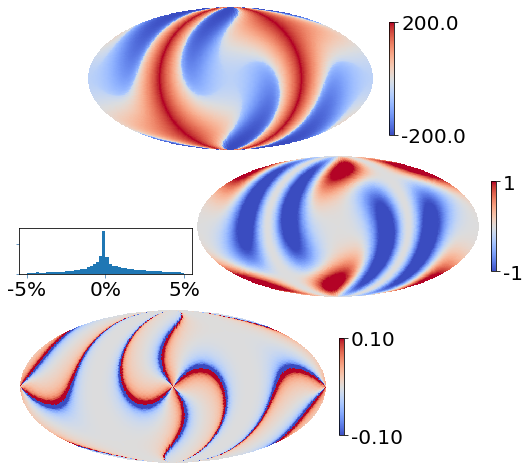

In [5]:
# radial resolution at 1% of total radius
precision_1shell_spin2(2.4,0.01)

end